In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='potato_leaf_ds.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('potato_leaf_ds.zip')
f.keys()
!unzip potato_leaf_ds.zip

Archive:  potato_leaf_ds.zip
replace potato_leaf_ds/train/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: potato_leaf_ds/train/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early.B 7136.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/0604174e-3018-4faa-9975-0be32d2c0789___RS_Early.B 7123.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/07953ca1-8935-449f-b338-4357ed683b2d___RS_Early.B 6815.JPG  
  inflating: potato_leaf_ds/train/Potato___Early_blight/08029ccc-387e-4be6-9389-04f7b82fdb2a___RS_Early.B 9130.JPG  
 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.12.0


In [ ]:
train_dir = '/content/potato_leaf_ds/train'
validation_dir = '/content/potato_leaf_ds/validation'
test_dir = '/content/potato_leaf_ds/validation'

BATCH_SIZE = 20
IMG_SIZE = (224, 224)
no_classes = 3

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1145 files belonging to 3 classes.
Found 1007 files belonging to 3 classes.
Found 1007 files belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
       
    ],
    name="img_augmentation",
)

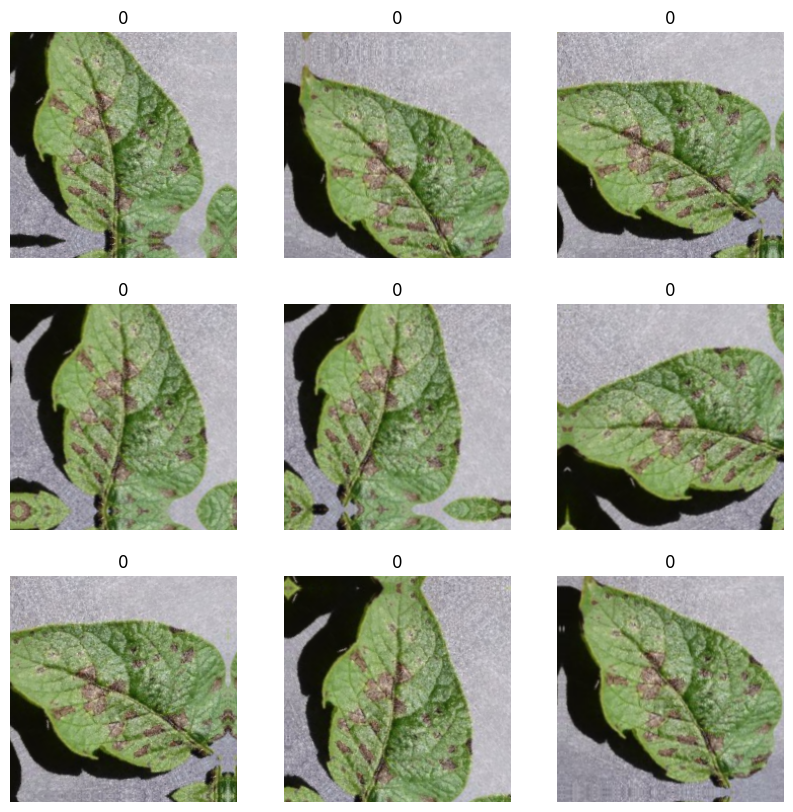

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = img_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.MobileNetV2 (
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
nb_classes = 3
inputs = keras.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
#x = Flatten()(x)
x = keras.layers.Dense(512, activation="relu")(x)
#x = keras.layers.Dropout(0.3)(x)

outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy']) 

In [ ]:
epochs = 30
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/30
58/58 [==============================] - 62s 161ms/step - loss: 0.2905 - accuracy: 0.8943 - val_loss: 19.8905 - val_accuracy: 0.5233
Epoch 2/30
58/58 [==============================] - 7s 117ms/step - loss: 0.1413 - accuracy: 0.9555 - val_loss: 2.0418 - val_accuracy: 0.7408
Epoch 3/30
58/58 [==============================] - 7s 124ms/step - loss: 0.0748 - accuracy: 0.9764 - val_loss: 14.3317 - val_accuracy: 0.4220
Epoch 4/30
58/58 [==============================] - 7s 125ms/step - loss: 0.0844 - accuracy: 0.9721 - val_loss: 38.3370 - val_accuracy: 0.4171
Epoch 5/30
58/58 [==============================] - 7s 117ms/step - loss: 0.1010 - accuracy: 0.9668 - val_loss: 26.8070 - val_accuracy: 0.4171
Epoch 6/30
58/58 [==============================] - 7s 116ms/step - loss: 0.1056 - accuracy: 0.9686 - val_loss: 27.5523 - val_accuracy: 0.4171
Epoch 7/30
58/58 [==============================] - 7s 125ms/step - loss: 0.0709 - accuracy: 0.9799 - val_loss: 11.6239 - val_accuracy: 0.4578

In [ ]:
scores = model.evaluate(test_dataset)

51/51 [==============================] - 2s 31ms/step - loss: 0.4113 - accuracy: 0.9424


In [ ]:
class_names = test_dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


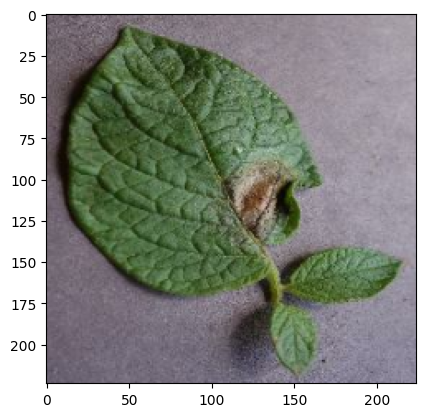

In [ ]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 74ms/step


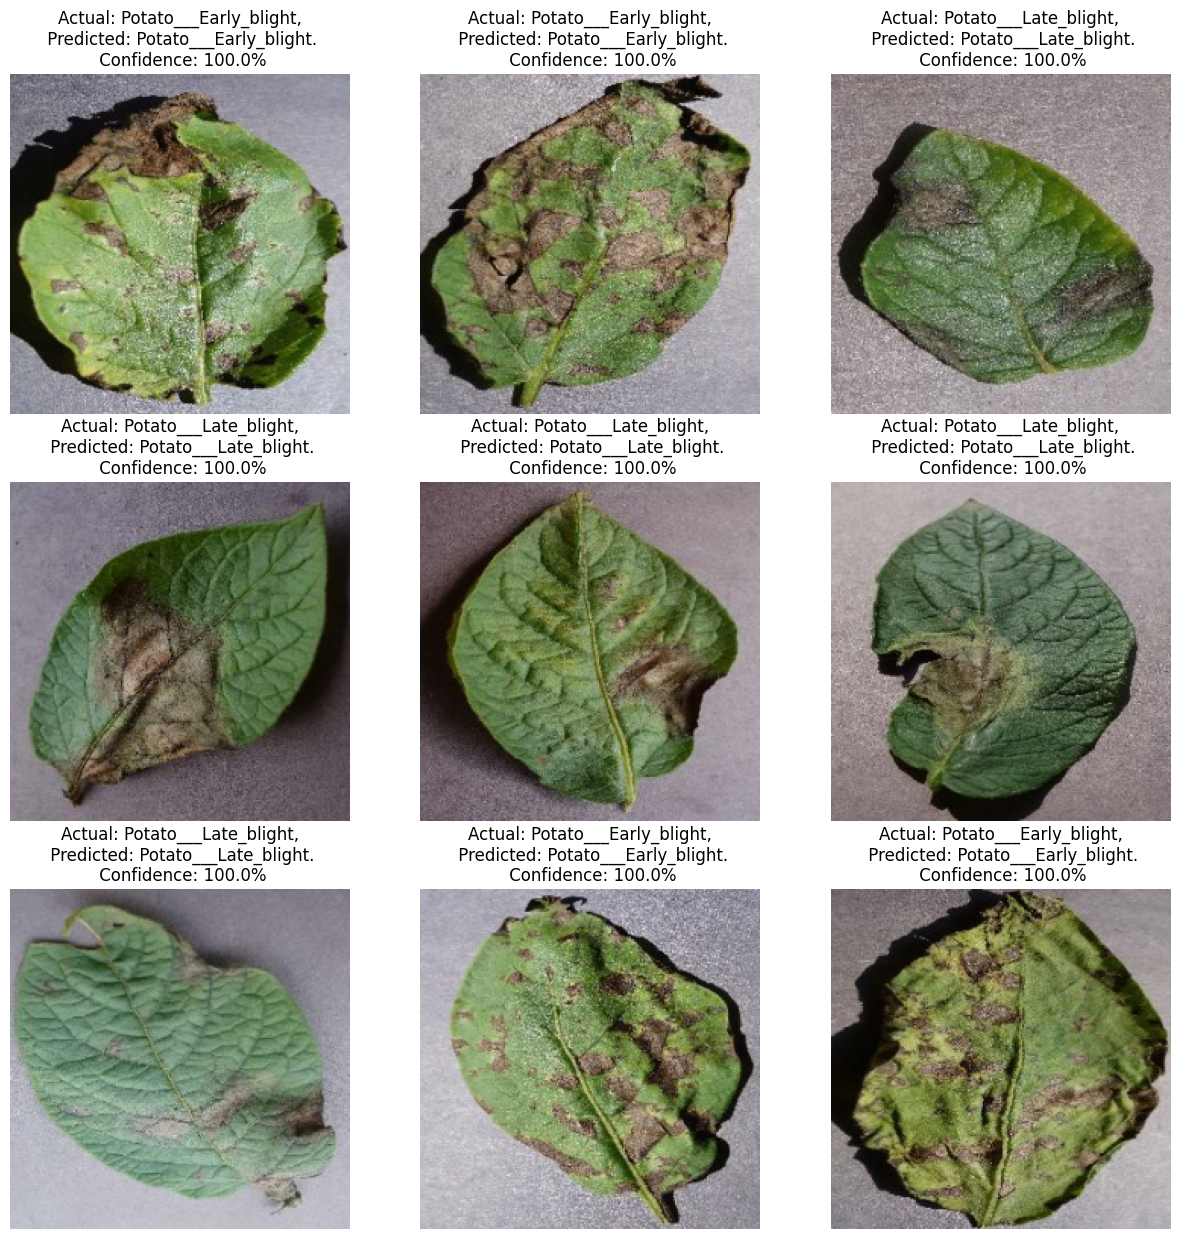

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")